# Brats 数据测试



In [7]:
import os
import torch
import numpy as np
import h5py

import nibabel as nib
from torch.utils.data import Dataset
from torchvision import transforms

from torch.nn.functional import one_hot

class BRATS2021(Dataset):
    def __init__(self, data_file, transform=None, local_train=False, length=None):
        super().__init__()
        """
        Args:
            data_file (str): 数据文件路径
            transform (callable, optional): 数据变换函数
            local_train (bool, optional): 是否只加载少量数据
            length (int, optional): 加载的局部数据量
        """
        assert os.path.exists(data_file), f"{data_file} does not exist"\
        
        # 
        self.data_file = data_file
        self.transform = transform

        # 读取少量数据
        self.local_train = local_train
        self.length = length

        # 获取数据路径列表
        self.data_paths_list = self.get_data_list() if not self.local_train else self.get_data_list()[:length]

            
    def load_data(self, h5_path):
        assert os.path.exists(h5_path), f"{h5_path} does not exist"

        # 从h5文件中读取数据
        with h5py.File(h5_path, 'r') as hf:
            data = hf['data'][:]
            mask = hf['mask'][:]

        # 数据预处理
        data = np.transpose(data, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))

        # 数据类型转换

        return data, mask

    def get_data_list(self):
        paths = []
        with open(self.data_file) as f:
            for line in f:
                path = line.strip()
                paths.append(path)
        return paths

    def __len__(self):
        return len(self.data_paths_list)

    def __getitem__(self, index):
        data, mask = self.load_data(self.data_paths_list[index])
        return data, mask


In [14]:

data_file = '/mnt/d/AI_Research/WS-Hub/Wsl-MedSeg/SliceMedix/data/train_paths.txt'
dataset = BRATS2021(data_file, local_train=True, length=10)
print(len(dataset))
test_data, test_mask = dataset[0]
print(f"shape of test_data: {test_data.shape}")
print(f"shape of test_mask: {test_mask.shape}")





10
shape of test_data: (240, 240, 155)
shape of test_mask: (240, 240, 155)


## 数据预处理
- 随机裁剪（RandomCrop）：从图像中随机裁剪出固定大小的区域，以增加数据的多样性。
- 标准化（Standardization）：将图像的像素值缩放到0到1之间，或者使用特定的均值和标准差进行归一化。
- 归一化（Normalization）：将图像的像素值缩放到特定的范围，例如[-1, 1]或[0, 255]。
- 翻转（Flip）：随机水平或垂直翻转图像，以增加数据的多样性。
- 旋转（Rotation）：随机旋转图像，以增加数据的多样性。
- 缩放（Resize）：调整图像的大小，以适应模型输入的要求。

In [84]:
import numpy as np
from torchvision import transforms as T
from torchvision.transforms import functional as F

def ToTensor(data, mask):
    data = F.to_tensor(data).to(torch.float32)
    mask = F.to_tensor(mask)
    return data, mask
    
def RandomCrop(data, mask, crop_size):
    assert data.shape == mask.shape, "data and mask must have the same shape"
    assert len(data.shape) == 3, "data must be a 3D array"

    # 随机裁剪
    d, h, w = data.shape
    crop_h, crop_w, crop_d = crop_size
    start_h = np.random.randint(0, h - crop_h) if crop_h < h else 0
    start_w = np.random.randint(0, w - crop_w) if crop_w < w else 0
    start_d = (d - crop_d) // 2

    data_cropped = data[start_d:start_d+crop_d, start_w:start_w+crop_w, start_h:start_h+crop_h]
    mask_cropped = mask[start_d:start_d+crop_d, start_w:start_w+crop_w, start_h:start_h+crop_h]

    return data_cropped, mask_cropped

def RandomFlip(data, mask, axis=0):
    assert data.shape == mask.shape, "data and mask must have the same shape"
    assert len(data.shape) == 3, "data must be a 3D array"

    # 随机翻转
    if np.random.rand() > 0.5:
        data = np.flip(data, axis)
        mask = np.flip(mask, axis)

    return data, mask

def Normalize(data, mask):
    assert data.shape == mask.shape, "data and mask must have the same shape"
    data = (data - data.mean()) / data.std()
    mask = (mask - mask.mean() / mask.std())

    return data, mask

In [86]:
test_data_processing, test_mask_processing = ToTensor(test_data, test_mask)
test_data_processing, test_mask_processing = RandomCrop(test_data_processing, test_mask_processing, (240, 240, 155))
test_data_processing, test_mask_processing = Normalize(test_data_processing, test_mask_processing)

print(f"shape of test_data_processing: {test_data_processing.shape}")
print(f"shape of test_mask_processing: {test_mask_processing.shape}")

print(test_data_processing.unique())

shape of test_data_processing: torch.Size([155, 240, 240])
shape of test_mask_processing: torch.Size([155, 240, 240])
tensor([-3.8876e-01, -3.7342e-01, -3.5807e-01, -3.4273e-01, -3.2738e-01,
        -3.1204e-01, -2.9669e-01, -2.8135e-01, -2.6601e-01, -2.5066e-01,
        -2.3532e-01, -2.1997e-01, -2.0463e-01, -1.8928e-01, -1.7394e-01,
        -1.5859e-01, -1.4325e-01, -1.2791e-01, -1.1256e-01, -9.7217e-02,
        -8.1872e-02, -6.6528e-02, -5.1183e-02, -3.5839e-02, -2.0494e-02,
        -5.1496e-03,  1.0195e-02,  2.5539e-02,  4.0884e-02,  5.6228e-02,
         7.1573e-02,  8.6917e-02,  1.0226e-01,  1.1761e-01,  1.3295e-01,
         1.4830e-01,  1.6364e-01,  1.7898e-01,  1.9433e-01,  2.0967e-01,
         2.2502e-01,  2.4036e-01,  2.5571e-01,  2.7105e-01,  2.8640e-01,
         3.0174e-01,  3.1708e-01,  3.3243e-01,  3.4777e-01,  3.6312e-01,
         3.7846e-01,  3.9381e-01,  4.0915e-01,  4.2450e-01,  4.3984e-01,
         4.5519e-01,  4.7053e-01,  4.8587e-01,  5.0122e-01,  5.1656e-01,
      

Text(0.5, 1.0, 'Test Data processing')

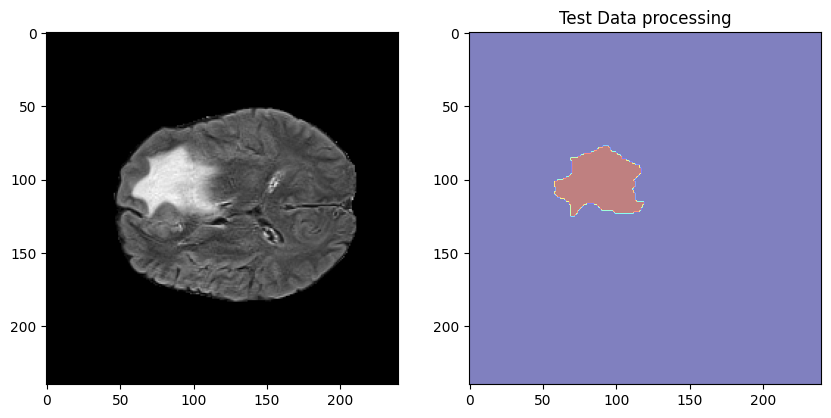

In [87]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_data_processing[80, :, :], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(test_mask_processing[80, :, :], cmap='jet', alpha=0.5)
plt.title('Test Data processing')
plt.title('Test Data processing')